In [ ]:
# import dependencies
import numpy as np
import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from skimage.transform import resize
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
# Define fixed pixel spacing and conversion factors
PIXEL_SPACING = 0.68359375  # mm
SLICE_THICKNESS = 2.5  # mm (standard CT slice thickness)
PIXEL_AREA = PIXEL_SPACING * PIXEL_SPACING  # mm²
MM3_TO_LITERS = 1/1000000  # conversion from mm³ to liters

def load_nifti_2d(file_path):
    """Load a 2D NIfTI file and return its data"""
    img = nib.load(file_path)
    return img.get_fdata().squeeze().T

def calculate_volume(binary_mask):
    """
    Calculate volume from a 2D binary mask
    
    Args:
        binary_mask: 2D numpy array of binary mask
    Returns:
        volume in liters
    """
    area_mm2 = np.sum(binary_mask) * PIXEL_AREA
    volume_mm3 = area_mm2 * SLICE_THICKNESS
    return volume_mm3 * MM3_TO_LITERS

def process_synthetic_image(img_data, lung_mask):
    """Process synthetic image and calculate lung volume using the mask"""
    return calculate_volume(lung_mask.astype(bool))

def threshold_and_fill(img_data, hu_threshold=-600):
    """
    Threshold image and apply hole filling
    
    Args:
        img_data: 2D numpy array of image data
        hu_threshold: HU value for thresholding
    Returns:
        binary mask after thresholding and hole filling
    """
    # Initial thresholding
    binary_mask = img_data < hu_threshold
    
    # Fill holes in the binary mask
    filled_mask = ndimage.binary_fill_holes(binary_mask)
    
    # Keep only the largest components (likely lungs)
    labeled_array, num_features = ndimage.label(filled_mask)
    if num_features > 1:
        sizes = np.bincount(labeled_array.ravel())
        if len(sizes) > 1:
            sizes[0] = 0  # Exclude background
            if len(sizes) > 2:
                largest_two = np.argsort(sizes)[-2:]
                mask = np.isin(labeled_array, largest_two)
            else:
                mask = filled_mask
        else:
            mask = filled_mask
    else:
        mask = filled_mask
    
    return mask

def process_predicted_image(img_data, target_shape):
    """
    Process predicted image with resizing, thresholding and hole filling
    
    Args:
        img_data: 2D numpy array of predicted image
        target_shape: tuple of target dimensions (height, width)
    Returns:
        volume in liters
    """
    # Resize predicted image to match input dimensions
    if img_data.shape != target_shape:
        img_data = resize(img_data, target_shape, preserve_range=True, anti_aliasing=True)
    
    # Apply thresholding and hole filling
    binary_mask = threshold_and_fill(img_data)
    return calculate_volume(binary_mask)

def create_bland_altman_plot(true_volumes, pred_volumes):
    """Create Bland-Altman plot for volume comparison in liters"""
    mean = np.mean([true_volumes, pred_volumes], axis=0)
    diff = true_volumes - pred_volumes
    
    md = np.mean(diff)
    sd = np.std(diff)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bland-Altman plot
    ax1.scatter(mean, diff, alpha=0.5)
    ax1.axhline(md, color='red', linestyle='--', label=f'Mean diff: {md:.3f} L')
    ax1.axhline(md + 1.96*sd, color='gray', linestyle='--', 
                label=f'+1.96 SD: {(md + 1.96*sd):.3f} L')
    ax1.axhline(md - 1.96*sd, color='gray', linestyle='--',
                label=f'-1.96 SD: {(md - 1.96*sd):.3f} L')
    
    ax1.set_xlabel('Mean Lung Area')
    ax1.set_ylabel('Difference in Area (True - Predicted)')
    ax1.set_title('Bland-Altman Plot')
    ax1.legend()
    
    # Correlation plot
    ax2.scatter(true_volumes, pred_volumes, alpha=0.5)
    min_val = min(true_volumes.min(), pred_volumes.min())
    max_val = max(true_volumes.max(), pred_volumes.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='Identity line')
    ax2.set_xlabel('True Lung  Area')
    ax2.set_ylabel('Predicted Lung Area')
    ax2.set_title('Correlation Plot')
    
    r = np.corrcoef(true_volumes, pred_volumes)[0,1]
    ax2.text(0.05, 0.95, f'r = {r:.3f}', transform=ax2.transAxes)
    
    plt.tight_layout()
    return plt



In [ ]:
# Set up paths
synthetic_dir = Path('synthetic_path')
predicted_dir = Path('predicted_path')

results = []

print(f"Using fixed pixel spacing of {PIXEL_SPACING} mm")
print(f"Using slice thickness of {SLICE_THICKNESS} mm")

# Process all IMG files in synthetic directory
for img_file in synthetic_dir.glob('*IMG.nii.gz'):
    case_id = img_file.name.split('IMG')[0]
    
    # Find corresponding files
    lung_file = img_file.parent / f"{case_id}LUNG.nii.gz"
    pred_files = list(predicted_dir.glob(f"{case_id}*.nii.gz"))
    
    if not lung_file.exists() or not pred_files:
        print(f"Skipping {case_id}: Missing required files")
        continue
    
    try:
        # Load files
        img_data = load_nifti_2d(img_file)
        lung_data = load_nifti_2d(lung_file)
        pred_data = load_nifti_2d(pred_files[0])
        
        # Print dimensions for debugging
        print(f"\nCase {case_id} dimensions:")
        print(f"  Original image: {img_data.shape}")
        print(f"  Lung mask: {lung_data.shape}")
        print(f"  Predicted image: {pred_data.shape}")
        
        # Calculate volumes
        true_vol = process_synthetic_image(img_data, lung_data)
        pred_vol = process_predicted_image(pred_data, img_data.shape)
        
        results.append({
            'case_id': case_id,
            'true_volume_L': true_vol,
            'pred_volume_L': pred_vol,
            'difference_L': true_vol - pred_vol,
            'original_shape': str(img_data.shape),
            'predicted_shape': str(pred_data.shape)
        })
        
        print(f"Processed {case_id}:")
        print(f"  True area = {true_vol:.3f} ")
        print(f"  Predicted area = {pred_vol:.3f} ")
        print(f"  Difference = {true_vol - pred_vol:.3f} ")
        
    except Exception as e:
        print(f"Error processing {case_id}: {str(e)}")
        continue

# Convert results to DataFrame
df = pd.DataFrame(results)

# Create arrays for plotting
true_volumes = df['true_volume_L'].values
pred_volumes = df['pred_volume_L'].values

# Generate and save plots
plt = create_bland_altman_plot(true_volumes, pred_volumes)
plt.savefig('lung_volume_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Number of cases processed: {len(df)}")
print(f"Mean true area: {df['true_volume_L'].mean():.3f} L")
print(f"Mean predicted area: {df['pred_volume_L'].mean():.3f} L")
print(f"Mean absolute difference: {df['difference_L'].abs().mean():.3f} L")
print(f"Correlation coefficient: {np.corrcoef(true_volumes, pred_volumes)[0,1]:.3f}")

# Save detailed results
df.to_csv('lung_volume_results.csv', index=False)

In [2]:
df = pd.read_csv('lung_volume_results.csv')

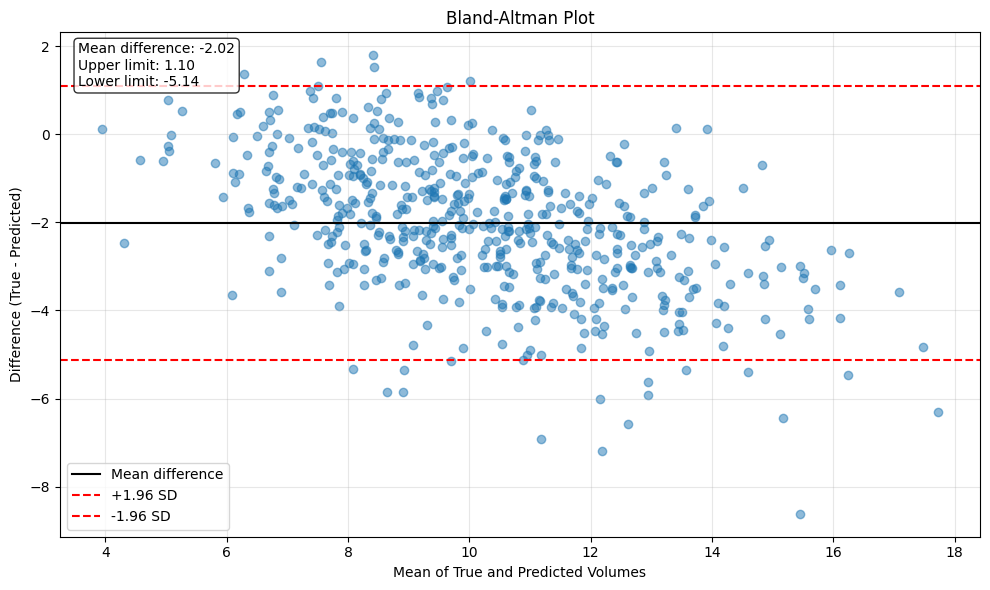

In [5]:
def create_bland_altman_plot(df, case_id_col='case_id', true_col='true_volume_L', pred_col='pred_volume_L'):
    """
    Create a Bland-Altman plot from grouped volume data.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing case_id, true_vol, and pred_vol columns
    case_id_col (str): Name of the case ID column
    true_col (str): Name of the true volume column
    pred_col (str): Name of the predicted volume column
    """
    # Group by case_id and sum volumes
    grouped_df = df.groupby(case_id_col).agg({
        true_col: 'sum',
        pred_col: 'sum'
    }).reset_index()
    
    # Calculate differences and means
    differences = grouped_df[true_col] - grouped_df[pred_col]
    means = (grouped_df[true_col] + grouped_df[pred_col]) / 2
    
    # Calculate mean difference and limits of agreement
    mean_diff = np.mean(differences)
    std_diff = np.std(differences)
    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff
    
    # Create the Bland-Altman plot
    plt.figure(figsize=(10, 6))
    plt.scatter(means, differences, alpha=0.5)
    
    # Add horizontal lines for mean difference and limits of agreement
    plt.axhline(y=mean_diff, color='k', linestyle='-', label='Mean difference')
    plt.axhline(y=upper_limit, color='r', linestyle='--', label='+1.96 SD')
    plt.axhline(y=lower_limit, color='r', linestyle='--', label='-1.96 SD')
    
    # Customize plot
    plt.xlabel('Mean of True and Predicted Volumes')
    plt.ylabel('Difference (True - Predicted)')
    plt.title('Bland-Altman Plot')
    plt.legend()
    
    # Add text annotations for statistics
    stats_text = f'Mean difference: {mean_diff:.2f}\n'
    stats_text += f'Upper limit: {upper_limit:.2f}\n'
    stats_text += f'Lower limit: {lower_limit:.2f}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Calculate and return summary statistics
    stats = {
        'mean_difference': mean_diff,
        'std_difference': std_diff,
        'upper_limit': upper_limit,
        'lower_limit': lower_limit,
        'n_cases': len(grouped_df)
    }
    
    return stats

# Example usage:
# Assuming your data is in a DataFrame called 'data'
stats = create_bland_altman_plot(df)
plt.show()

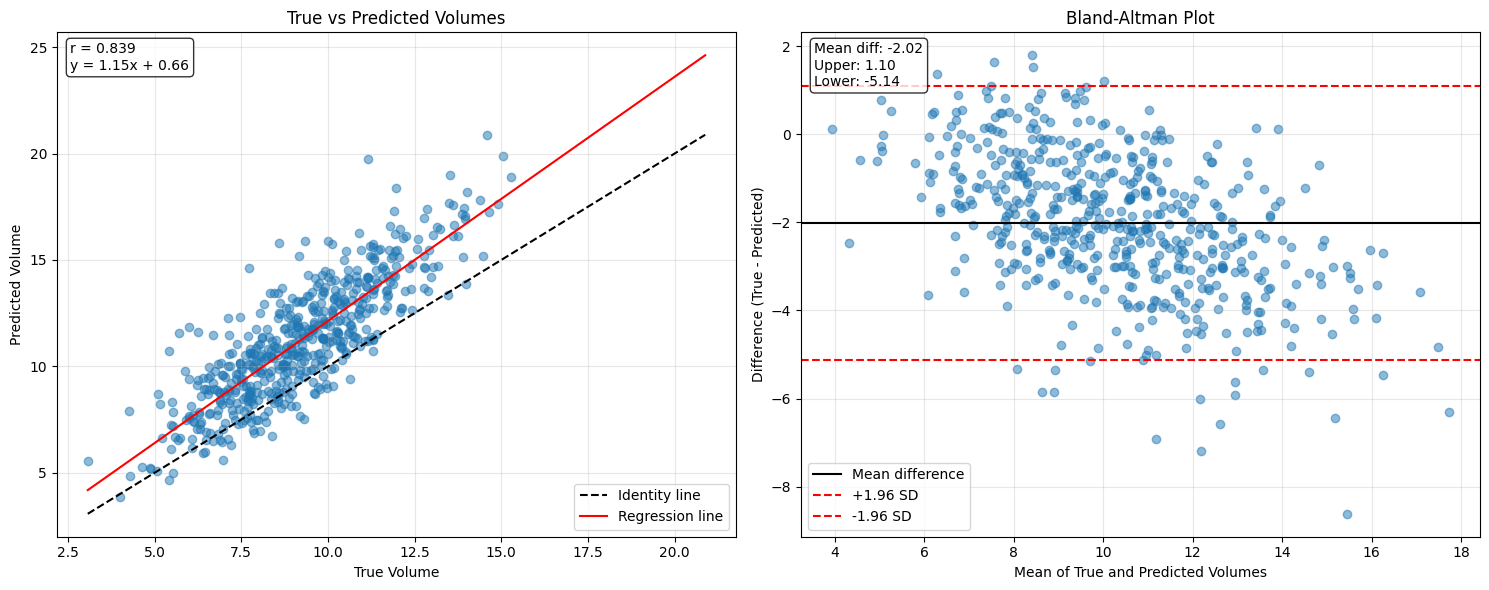

In [ ]:
def analyze_volumes(df, case_id_col='case_id', true_col='true_volume_L', pred_col='pred_volume_L'):
    """
    Create both scatter and Bland-Altman plots from grouped volume data.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing case_id, true_vol, and pred_vol columns
    case_id_col (str): Name of the case ID column
    true_col (str): Name of the true volume column
    pred_col (str): Name of the predicted volume column
    """
    # Group by case_id and sum volumes
    grouped_df = df.groupby(case_id_col).agg({
        true_col: 'sum',
        pred_col: 'sum'
    }).reset_index()
    
    # Calculate differences and means for Bland-Altman
    differences = grouped_df[true_col] - grouped_df[pred_col]
    means = (grouped_df[true_col] + grouped_df[pred_col]) / 2
    
    # Calculate statistics
    mean_diff = np.mean(differences)
    std_diff = np.std(differences)
    upper_limit = mean_diff + 1.96 * std_diff
    lower_limit = mean_diff - 1.96 * std_diff
    
    # Calculate correlation coefficient and linear regression
    correlation = stats.pearsonr(grouped_df[true_col], grouped_df[pred_col])[0]
    slope, intercept, r_value, p_value, std_err = stats.linregress(grouped_df[true_col], grouped_df[pred_col])
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot
    ax1.scatter(grouped_df[true_col], grouped_df[pred_col], alpha=0.5)
    
    # Add identity line (y=x)
    min_val = min(grouped_df[true_col].min(), grouped_df[pred_col].min())
    max_val = max(grouped_df[true_col].max(), grouped_df[pred_col].max())
    identity_line = np.linspace(min_val, max_val, 100)
    ax1.plot(identity_line, identity_line, 'k--', label='Identity line')
    
    # Add regression line
    regression_line = slope * identity_line + intercept
    ax1.plot(identity_line, regression_line, 'r-', label='Regression line')
    
    # Customize scatter plot
    ax1.set_xlabel('True Volume')
    ax1.set_ylabel('Predicted Volume')
    ax1.set_title('True vs Predicted Volumes')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add correlation info
    scatter_stats = f'r = {correlation:.3f}\ny = {slope:.2f}x + {intercept:.2f}'
    ax1.text(0.02, 0.98, scatter_stats, transform=ax1.transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Bland-Altman plot
    ax2.scatter(means, differences, alpha=0.5)
    
    # Add horizontal lines
    ax2.axhline(y=mean_diff, color='k', linestyle='-', label='Mean difference')
    ax2.axhline(y=upper_limit, color='r', linestyle='--', label='+1.96 SD')
    ax2.axhline(y=lower_limit, color='r', linestyle='--', label='-1.96 SD')
    
    # Customize Bland-Altman plot
    ax2.set_xlabel('Mean of True and Predicted Volumes')
    ax2.set_ylabel('Difference (True - Predicted)')
    ax2.set_title('Bland-Altman Plot')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add Bland-Altman stats
    ba_stats = f'Mean diff: {mean_diff:.2f}\nUpper: {upper_limit:.2f}\nLower: {lower_limit:.2f}'
    ax2.text(0.02, 0.98, ba_stats, transform=ax2.transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Calculate and return summary statistics
    stats_dict = {
        'mean_difference': mean_diff,
        'std_difference': std_diff,
        'upper_limit': upper_limit,
        'lower_limit': lower_limit,
        'correlation': correlation,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2,
        'n_cases': len(grouped_df)
    }
    
    return stats_dict

# Example usage:
# Assuming your data is in a DataFrame called 'data'
stats = analyze_volumes(df)
plt.show()


Detailed Statistical Analysis:
Number of cases: 551
R-squared: -0.500

Paired t-test results:
t-statistic: -29.737
p-value: 1.446e-116
Mean difference: 2.02 L
Standard deviation of differences: 1.59 L
95% Limits of agreement: (-1.10, 5.14) L

Descriptive Statistics:

True Volume (L):
count    551.000000
mean       9.213977
std        2.099718
min        3.073135
25%        7.736294
50%        9.128856
75%       10.576090
max       15.291052
Name: true_volume_L, dtype: float64

Predicted Volume (L):
count    551.000000
mean      11.231302
std        2.871111
min        3.877579
25%        9.092614
50%       11.069077
75%       13.198333
max       20.880594
Name: pred_volume_L, dtype: float64


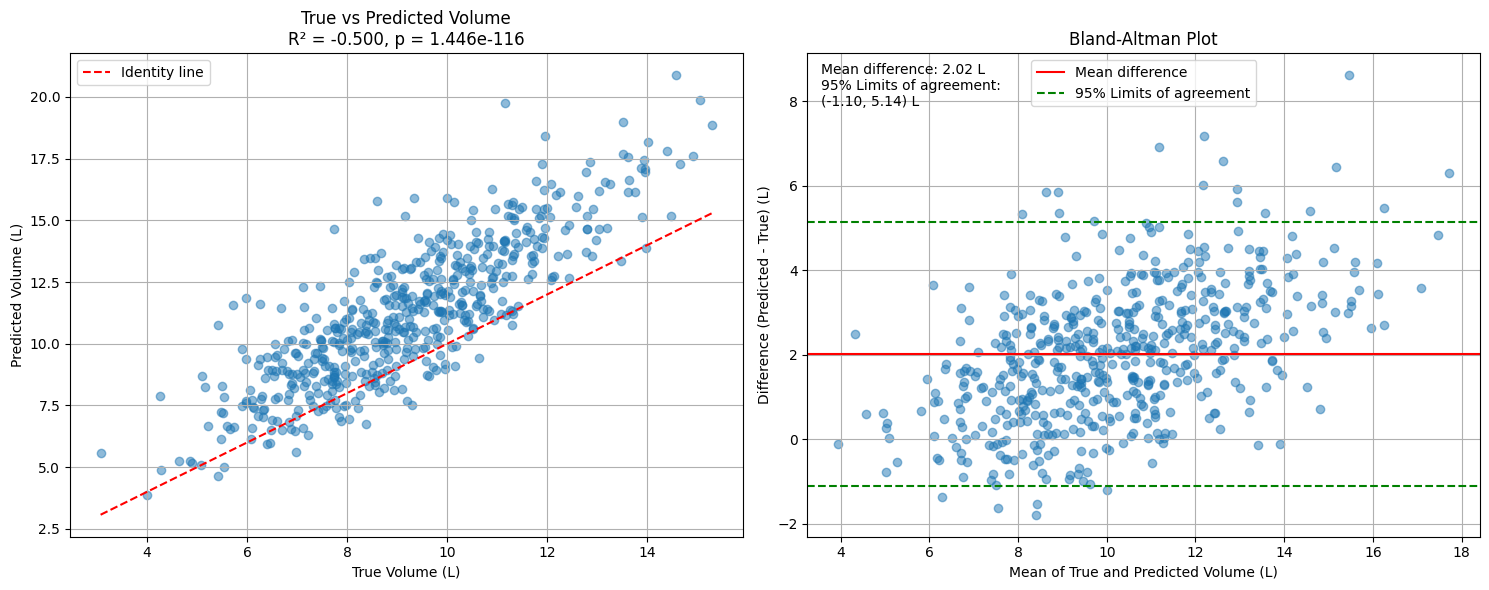

In [ ]:
# Read the CSV file
df = pd.read_csv('/projectdir/lung_volume_results.csv')

# Group by case_id and sum the volumes
case_volumes = df.groupby('case_id').agg({
    'true_volume_L': 'sum',
    'pred_volume_L': 'sum'
}).reset_index()

# Perform linear regression
X = case_volumes['true_volume_L'].values.reshape(-1, 1)
y = case_volumes['pred_volume_L'].values
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
r2_regression = r2_score(y, y_pred)

# Calculate R-squared for identity line (1:1 relationship)
r2_identity = r2_score(case_volumes['true_volume_L'], case_volumes['pred_volume_L'])

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(case_volumes['true_volume_L'], 
                                 case_volumes['pred_volume_L'])

# Calculate mean and difference for Bland-Altman
mean_volumes = (case_volumes['true_volume_L'] + case_volumes['pred_volume_L']) / 2
diff_volumes = case_volumes['pred_volume_L'] - case_volumes['true_volume_L']

# Calculate mean difference and limits of agreement
mean_diff = np.mean(diff_volumes)
std_diff = np.std(diff_volumes)
limits_of_agreement = (mean_diff - 1.96 * std_diff, mean_diff + 1.96 * std_diff)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Scatter plot with both lines
ax1.scatter(case_volumes['true_volume_L'], case_volumes['pred_volume_L'], alpha=0.5)
# Identity line
ax1.plot([case_volumes['true_volume_L'].min(), case_volumes['true_volume_L'].max()],
         [case_volumes['true_volume_L'].min(), case_volumes['true_volume_L'].max()],
         'r--', label=f'Identity line (R² = {r2_identity:.3f})')
# Best fit line
ax1.plot(X, y_pred, 'g-', label=f'Best fit (R² = {r2_regression:.3f})')
ax1.set_xlabel('True Volume (L)')
ax1.set_ylabel('Predicted Volume (L)')
ax1.set_title(f'True vs Predicted Volume\np = {p_value:.3e}\ny = {reg.coef_[0]:.3f}x + {reg.intercept_:.3f}')
ax1.grid(True)
ax1.legend()

# Plot 2: Bland-Altman plot
ax2.scatter(mean_volumes, diff_volumes, alpha=0.5)
ax2.axhline(y=mean_diff, color='r', linestyle='-', label='Mean difference')
ax2.axhline(y=limits_of_agreement[0], color='g', linestyle='--', label='95% Limits of agreement')
ax2.axhline(y=limits_of_agreement[1], color='g', linestyle='--')
ax2.set_xlabel('Mean of True and Predicted Volume (L)')
ax2.set_ylabel('Difference (Predicted - True) (L)')
ax2.set_title('Bland-Altman Plot')

# Add text annotations for statistics on Bland-Altman plot
ax2.text(0.02, 0.98, f'Mean difference: {mean_diff:.2f} L\n95% Limits of agreement:\n({limits_of_agreement[0]:.2f}, {limits_of_agreement[1]:.2f}) L',
         transform=ax2.transAxes, verticalalignment='top')
ax2.legend()
ax2.grid(True)

plt.tight_layout()

# Calculate and print detailed statistics
print("\nDetailed Statistical Analysis:")
print(f"Number of cases: {len(case_volumes)}")
print("\nRegression Analysis:")
print(f"Slope: {reg.coef_[0]:.3f}")
print(f"Intercept: {reg.intercept_:.3f}")
print(f"R-squared (best fit): {r2_regression:.3f}")
print(f"R-squared (identity): {r2_identity:.3f}")
print("\nPaired t-test results:")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.3e}")
print(f"Mean difference: {mean_diff:.2f} L")
print(f"Standard deviation of differences: {std_diff:.2f} L")
print(f"95% Limits of agreement: ({limits_of_agreement[0]:.2f}, {limits_of_agreement[1]:.2f}) L")

# Additional descriptive statistics
print("\nDescriptive Statistics:")
print("\nTrue Volume (L):")
print(case_volumes['true_volume_L'].describe())
print("\nPredicted Volume (L):")
print(case_volumes['pred_volume_L'].describe())

plt.show()

In [ ]:
def compute_dice_coefficients(mask1, mask2):
    """
    Compute both surface and regular Dice coefficients for 3D binary masks.
    
    Args:
        mask1, mask2: 3D numpy arrays with binary values (0 and 1)
        
    Returns:
        tuple: (surface_dice, regular_dice)
    """
    # Get surface voxels using 3D convolution
    kernel = np.ones((3,3,3))
    kernel[1,1,1] = 0
    
    def get_surface(mask):
        padded = np.pad(mask, pad_width=1, mode='constant', constant_values=0)
        neighbors = ndimage.convolve(padded, kernel, mode='constant', cval=0)[1:-1,1:-1,1:-1]
        return (mask.astype(bool) & (neighbors > 0)).astype(int)
    
    surface1 = get_surface(mask1)
    surface2 = get_surface(mask2)
    
    # Surface Dice
    surface_intersection = np.sum(surface1 * surface2)
    surface_dice = 2.0 * surface_intersection / (np.sum(surface1) + np.sum(surface2))
    
    # Regular Dice
    intersection = np.sum(mask1 * mask2)
    dice = 2.0 * intersection / (np.sum(mask1) + np.sum(mask2))
    
    return surface_dice, dice

In [ ]:
# Set up paths
synthetic_dir = Path('/projectdir/mesa_synthetic_CAC_slices/test')
predicted_dir = Path('/projectdir/results/nov14/nifti')

results = []

# Process all IMG files in synthetic directory
for img_file in synthetic_dir.glob('*IMG.nii.gz'):
    case_id = img_file.name.split('IMG')[0]
    
    # Find corresponding files
    lung_file = img_file.parent / f"{case_id}LUNG.nii.gz"
    pred_files = list(predicted_dir.glob(f"{case_id}*.nii.gz"))
    
    if not lung_file.exists() or not pred_files:
        print(f"Skipping {case_id}: Missing required files")
        continue
    
    try:
        # Load files
        img_data = load_nifti_2d(img_file)
        lung_data = load_nifti_2d(lung_file)
        pred_data = load_nifti_2d(pred_files[0])
        
        surface, dice = compute_dice_coefficients(img_data, pred_data)
        
        results.append({
            'case_id': case_id,
            'true_volume_L': true_vol,
            'pred_volume_L': pred_vol,
            'difference_L': true_vol - pred_vol,
            'original_shape': str(img_data.shape),
            'predicted_shape': str(pred_data.shape)
        })
        
        print(f"Processed {case_id}:")
        print(f"  True area = {true_vol:.3f} ")
        print(f"  Predicted area = {pred_vol:.3f} ")
        print(f"  Difference = {true_vol - pred_vol:.3f} ")
        
    except Exception as e:
        print(f"Error processing {case_id}: {str(e)}")
        continue

# Convert results to DataFrame
df = pd.DataFrame(results)
